In [1]:
# Importing the necessary libraries
import platform
print("Python version:", platform.python_version())

import sys
import os

import torch
print("torch version:", torch.__version__)

import numpy as np
print("numpy version:", np.__version__)

import cv2
print("cv2 version:", cv2.__version__)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
print("matplotlib version:", matplotlib.__version__)

from PIL import Image

import pandas as pd
print("pandas version:", pd.__version__)

from skimage.transform import resize

import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim


Python version: 3.8.19
torch version: 2.4.0+cu124
numpy version: 1.24.1
cv2 version: 4.10.0
matplotlib version: 3.7.5
pandas version: 2.0.3


In [2]:
import logging

# Set up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Specify the log file path
log_file = "D:\\MTP\\Tokaidos\\log_file_weighted.log"  # Replace with your desired log file path

# Create a file handler to write log records to the log file in 'append' mode
file_handler = logging.FileHandler(log_file, mode='a')

# Create a formatter for the log records
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the file handler to the logger
logger.addHandler(file_handler)

In [3]:
#Function to change the path format
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path

In [4]:
# Image and mask transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [6]:
#Loading the training data for damage images
#Access the csv file containing the absolute directory paths to each file
path_ds = 'D:\\MTP\\Tokaidos'
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name',
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]

In [7]:
print(len(train_dmg))
train_dmg

4381


,image file name,component label file name,damage label file name,depth image file name,camera focal length in mm
0,D:\MTP\Tokaidos\img_syn_raw/train/image_case0_...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,43.375470
3,D:\MTP\Tokaidos\img_syn_raw/train/image_case0_...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,43.242723
5,D:\MTP\Tokaidos\img_syn_raw/train/image_case0_...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,20.921244
7,D:\MTP\Tokaidos\img_syn_raw/train/image_case0_...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,46.639972
11,D:\MTP\Tokaidos\img_syn_raw/train/image_case0_...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,53.623157
...,...,...,...,...,...
13940,D:\MTP\Tokaidos\img_syn_raw/train/image_case17...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,51.725212
13941,D:\MTP\Tokaidos\img_syn_raw/train/image_case17...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,53.422408
13944,D:\MTP\Tokaidos\img_syn_raw/train/image_case17...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,41.561651
13948,D:\MTP\Tokaidos\img_syn_raw/train/image_case17...,D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...,D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...,D:\MTP\Tokaidos\synthetic/train/depth/image_ca...,36.669088


image file name                         D:\MTP\Tokaidos\img_syn_raw/train/image_case0_...
component label file name               D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...
damage label file name                  D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...
depth image file name                   D:\MTP\Tokaidos\synthetic/train/depth/image_ca...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(1080, 1920, 3)
<class 'numpy.ndarray'>


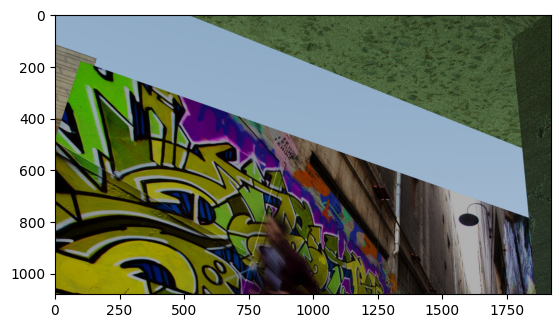

In [8]:
#Printing the training image

#image
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][0])
print(image.shape)
print(type(image))
plt.imshow(image)

image file name                         D:\MTP\Tokaidos\img_syn_raw/train/image_case0_...
component label file name               D:\MTP\Tokaidos\synthetic/train/labcmp/image_c...
damage label file name                  D:\MTP\Tokaidos\synthetic/train/labdmg/image_c...
depth image file name                   D:\MTP\Tokaidos\synthetic/train/depth/image_ca...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(360, 640)
<class 'numpy.ndarray'>


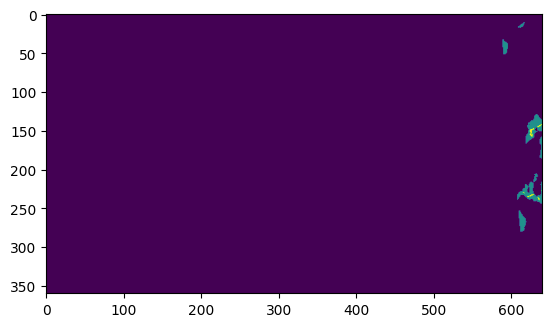

In [9]:
#label
#Printing the above image label
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][2])#[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}
print(image.shape)
print(type(image))
plt.imshow(image)

In [10]:
#Run for training on the damage images
train1 = train_dmg[:4000]
val1 = train_dmg[4000:]

image file name           D:\MTP\Tokaidos\images_puretex/im820_ConcreteD...
damage label file name    D:\MTP\Tokaidos\synthetic_puretex/labdmg/im820...
Name: 0, dtype: object
(360, 640)
<class 'numpy.ndarray'>


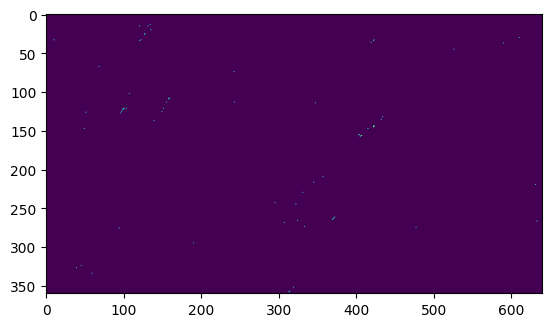

In [11]:
#Loading the training data from the pure_tex file

#Access the csv file containing the absolute directory paths to each file
path_ds = 'D:\\MTP\\Tokaidos' #put a path to the dataset
col_names = ['image file name', 'damage label file name']

ftrain = pd.read_csv(os.path.join(path_ds,'files_puretex_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))

train_tex = ftrain

#Printing the training image
print(ftrain.iloc[0])
image = mpimg.imread(ftrain.iloc[0][1])
print(image.shape)
print(type(image))
plt.imshow(image)

In [12]:
print(len(train_tex))
train_tex

2700


,image file name,damage label file name
0,D:\MTP\Tokaidos\images_puretex/im820_ConcreteD...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im820...
1,D:\MTP\Tokaidos\images_puretex/im418_ConcreteD...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im418...
2,D:\MTP\Tokaidos\images_puretex/im704_ConcreteD...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im704...
3,D:\MTP\Tokaidos\images_puretex/im2589_Concrete...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im258...
4,D:\MTP\Tokaidos\images_puretex/im962_ConcreteD...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im962...
...,...,...
2695,D:\MTP\Tokaidos\images_puretex/im763_ConcreteD...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im763...
2696,D:\MTP\Tokaidos\images_puretex/im835_ConcreteD...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im835...
2697,D:\MTP\Tokaidos\images_puretex/im1653_Concrete...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im165...
2698,D:\MTP\Tokaidos\images_puretex/im2607_Concrete...,D:\MTP\Tokaidos\synthetic_puretex/labdmg/im260...


In [13]:
# Append the first 2300 rows from 'train_tex' to 'train1'
train1 = pd.concat([train1, train_tex[:2300]])

# Append the remaining rows from 'train_tex' to 'val1'
val1 = pd.concat([val1, train_tex[2300:]])

### DATA PREPROSSessing 

In [21]:
# Function to get the label from the file_path
def get_label(file_path):
    mask = np.squeeze(file_path, axis=2)  # Remove the last axis if needed
    target_array = np.zeros((mask.shape[0], mask.shape[1], 3))
    target_array[:, :, 0] = np.where(mask == 1, 1, 0)
    target_array[:, :, 1] = np.where(mask == 2, 1, 0)
    target_array[:, :, 2] = np.where(mask == 3, 1, 0)
    return target_array

# Function to show an image
def show_img(image):
    image = image * 0.5 + 0.5
    image = image.permute(1, 2, 0)  # Convert to HxWxC format
    image = image.numpy()  # Convert to numpy array for display
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Function to show the label images
def show_label(label):
    fig, axes = plt.subplots(1, 3, figsize=(16, 112))
    y1 = label[:, :, 0]
    y2 = label[:, :, 1]
    y3 = label[:, :, 2]
    axes[0].imshow(y1)
    axes[1].imshow(y2)
    axes[2].imshow(y3)
    plt.axis('off')
    plt.show()

# Function to show prediction images
def show_pred(y, threshold=0.5):
    fig, axes = plt.subplots(1, 3, figsize=(16, 112))
    y1 = y[:, :, 0]
    y2 = y[:, :, 1]
    y3 = y[:, :, 2]
    axes[0].imshow(y1)
    axes[1].imshow(y2)
    axes[2].imshow(y3)
    plt.axis('off')
    plt.show()

# Function to normalize images
def normalize(input_image):
    input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0
    return input_image

# Function to perform image augmentation
def image_augmentation(img):
    # Convert image to PyTorch tensor if not already
    img = torch.tensor(img)
    if torch.rand(1).item() > 0.5:
        img = torch.flip(img, dims=[2])  # Flip image horizontally
    return img.numpy()

# Function to perform label augmentation
def label_augmentation(img):
    # Convert image to PyTorch tensor if not already
    img = torch.tensor(img)
    if torch.rand(1).item() > 0.5:
        img = torch.flip(img, dims=[2])  # Flip image horizontally
    return img.numpy()

In [22]:
def preprocess(x, y):
    def f(x, y):
        # Load images using PIL and convert to RGB
        x = Image.open(x).convert("RGB")
        y = Image.open(y).convert("L")  # Assuming the mask is a single channel image

        # Resize images with padding to 256x256
        x = transforms.functional.pad(x, padding=0, fill=0, padding_mode='constant')
        x = transforms.functional.resize(x, (256, 256))

        y = transforms.functional.pad(y, padding=0, fill=0, padding_mode='constant')
        y = transforms.functional.resize(y, (256, 256))
        
        # Normalize the image
        x = normalize(np.array(x))
        
        # Process the label (mask)
        y = get_label(np.array(y))
        
        # Perform data augmentation
        x = image_augmentation(x)
        y = label_augmentation(y)

        return x, y

    # Call the processing function and convert to torch tensors
    images, masks = f(x, y)    
    images = torch.tensor(images, dtype=torch.float32).permute(2, 0, 1)# Change to CxHxW format expected by PyTorch
    masks = torch.tensor(masks, dtype=torch.float32).permute(2, 0, 1)


    return images, masks

In [23]:
# Extract image and mask file paths from the CSV file
train_image_paths = train1['image file name'].values
train_mask_paths = train1['damage label file name'].values

val_image_paths = val1['image file name'].values
val_mask_paths = val1['damage label file name'].values

In [24]:
# Custom Dataset class for GANs
class GANDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")  # Ensure image has 3 channels

        if self.transform:
            image = self.transform(image)

        return image

# Define the transformations for images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
])

# Create the dataset and dataloader
image_paths = train_image_paths  # Assuming you have image paths ready
gan_dataset = GANDataset(image_paths, transform=transform)
gan_loader = DataLoader(gan_dataset, batch_size=64, shuffle=True)  # Batch size can be tuned
val_dataset = GANDataset(val_image_paths, transform=transform)

In [25]:
len(gan_dataset)

6300

In [26]:
len(val_dataset)

781

torch.Size([3, 256, 256])


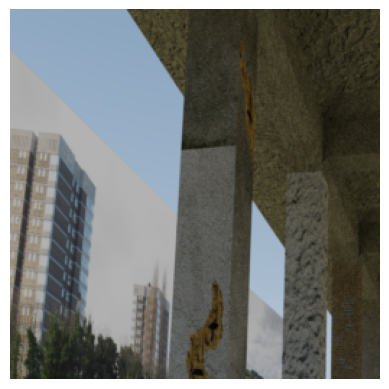

In [29]:
from PIL import Image

for batch in val_dataset:
    x = batch  # Should be a tensor of shape (3, 256, 256)
    print(x.shape)  # Ensure it's (3, 256, 256)
    show_img(x)  # Display the image
    break

### Model

In [33]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        if self.imsize == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)
            curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')
        self.attn2 = Self_Attn( 64,  'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out, p1, p2


class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, batch_size=64, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        if self.imsize == 64:
            layer4 = []
            layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim*2
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out.squeeze(), p1, p2